In [58]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from pandas_ods_reader import read_ods

from dateutil.parser import parse 
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

In [59]:
april = pd.read_csv('SiroveKopijeWebexMeetings/April2021_Webex Meetings_Attendees_matf.webex.com_2021-04-01_2021-04-30.csv', parse_dates=['JOIN_DATE'])
may = pd.read_csv('SiroveKopijeWebexMeetings/Maj2021_Webex Meetings_Attendees_matf.webex.com_2021-05-01_2021-05-31.csv', parse_dates=['JOIN_DATE'])

In [61]:
march = read_ods('SiroveKopijeWebexMeetings/Mart2021WebexMeetingsAttendees.ods', 1)
november = read_ods('SiroveKopijeWebexMeetings/NovembarWebex Meetings_Attendees_matf.webex.com_2020-11-01_2020-11-30.ods', 1)

In [62]:
april.head()

,MEETING_NUMBER,MEETING_NAME,CONFERENCE_ID,USER_NAME,EMAIL,LOCATION,JOIN_DATE,START_TIME,END_TIME,DURATION,...,GATEWAY_IP,JOIN_MEETING_TIME,VOIP_PACKET_LOSS,VOIP_LATENCY,TCP_PERCENTAGE,UDP_PERCENTAGE,IS_CMR,IS_SHARING,IS_RECORD,VIDEO_MINUTES
0,1834853439,МАТФ - Увод у веб и интернет технологије (вежб...,189215711830219865,Lena Polic,mi17219@alas.matf.bg.ac.rs,Serbia,2021-04-02,2021-04-02T10:13:34,2021-04-02T11:59:55,107,...,87.116.165.39,0.413,0.00065,50.000000,0.0,1.0,N,N,N,NaN
1,1830843747,"Analiza 3, I smer, 2. tok - vezbe",189755459960315839,Luka Radanovic,mi19169@alas.matf.bg.ac.rs,Serbia,2021-04-01,2021-04-01T09:06:19,2021-04-01T11:02:40,117,...,89.110.244.200,0.849,0.00000,50.000000,0.0,1.0,N,N,N,NaN
2,1833007854,EFM predavanja,189774169196469618,Ilija-Petar Milić,ipmilic@gmail.com,Serbia,2021-04-01,2021-04-01T13:05:16,2021-04-01T13:18:56,14,...,87.116.165.160,0.920,0.00000,50.000000,0.0,1.0,N,N,N,NaN
3,1837521894,Практикум из Анализе 1 - П12,189846157149609508,Jana Mihajlović,janamihajlovic04@gmail.com,Serbia,2021-04-02,2021-04-02T10:15:33,2021-04-02T10:58:13,43,...,109.92.158.89,2.188,0.00000,100.064482,0.0,1.0,N,N,N,NaN
4,1831753884,"г4, вежбе",190106877640580240,Dragana Maljković,mv17007@alas.matf.bg.ac.rs,Serbia,2021-04-05,2021-04-05T07:24:58,2021-04-05T09:07:37,103,...,178.221.45.78,40.543,0.00000,101.919657,0.0,1.0,N,N,N,NaN


In [63]:
april.shape

(22549, 23)

In [64]:
april.columns

Index(['MEETING_NUMBER', 'MEETING_NAME', 'CONFERENCE_ID', 'USER_NAME', 'EMAIL',
       'LOCATION', 'JOIN_DATE', 'START_TIME', 'END_TIME', 'DURATION', 'OS',
       'BROWSER', 'CLIENT_IP', 'GATEWAY_IP', 'JOIN_MEETING_TIME',
       'VOIP_PACKET_LOSS', 'VOIP_LATENCY', 'TCP_PERCENTAGE', 'UDP_PERCENTAGE',
       'IS_CMR', 'IS_SHARING', 'IS_RECORD', 'VIDEO_MINUTES'],
      dtype='object')

In [65]:
april.isnull().any()

MEETING_NUMBER       False
MEETING_NAME         False
CONFERENCE_ID        False
USER_NAME            False
EMAIL                 True
LOCATION             False
JOIN_DATE            False
START_TIME           False
END_TIME             False
DURATION             False
OS                   False
BROWSER              False
CLIENT_IP            False
GATEWAY_IP           False
JOIN_MEETING_TIME     True
VOIP_PACKET_LOSS      True
VOIP_LATENCY          True
TCP_PERCENTAGE        True
UDP_PERCENTAGE        True
IS_CMR               False
IS_SHARING           False
IS_RECORD            False
VIDEO_MINUTES         True
dtype: bool

In [66]:
april.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22549 entries, 0 to 22548
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   MEETING_NUMBER     22549 non-null  int64         
 1   MEETING_NAME       22549 non-null  object        
 2   CONFERENCE_ID      22549 non-null  int64         
 3   USER_NAME          22549 non-null  object        
 4   EMAIL              22543 non-null  object        
 5   LOCATION           22549 non-null  object        
 6   JOIN_DATE          22549 non-null  datetime64[ns]
 7   START_TIME         22549 non-null  object        
 8   END_TIME           22549 non-null  object        
 9   DURATION           22549 non-null  int64         
 10  OS                 22549 non-null  object        
 11  BROWSER            22549 non-null  object        
 12  CLIENT_IP          22549 non-null  object        
 13  GATEWAY_IP         22549 non-null  object        
 14  JOIN_M

In [71]:
meetings_per_day_april = april.groupby(['JOIN_DATE']).MEETING_NUMBER.count()
meetings_per_day_march = march.groupby(['JOIN_DATE']).MEETING_NUMBER.count()
meetings_per_day_november = november.groupby(['JOIN_DATE']).MEETING_NUMBER.count()
meetings_per_day_may = may.groupby(['JOIN_DATE']).MEETING_NUMBER.count()

meetings_per_day_march = meetings_per_day_march[:-1]
#meetings_per_day_march

In [72]:
def plot_df(df, x, y, title="", xlabel='Datum', ylabel='Vrednost', dpi=100):
    fig = plt.figure(figsize=(16,5), dpi=dpi)
    ax = fig.add_subplot(111)
    ax.plot(x, y, 'tab:purple')
    fig.autofmt_xdate()
    #plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
    plt.show()

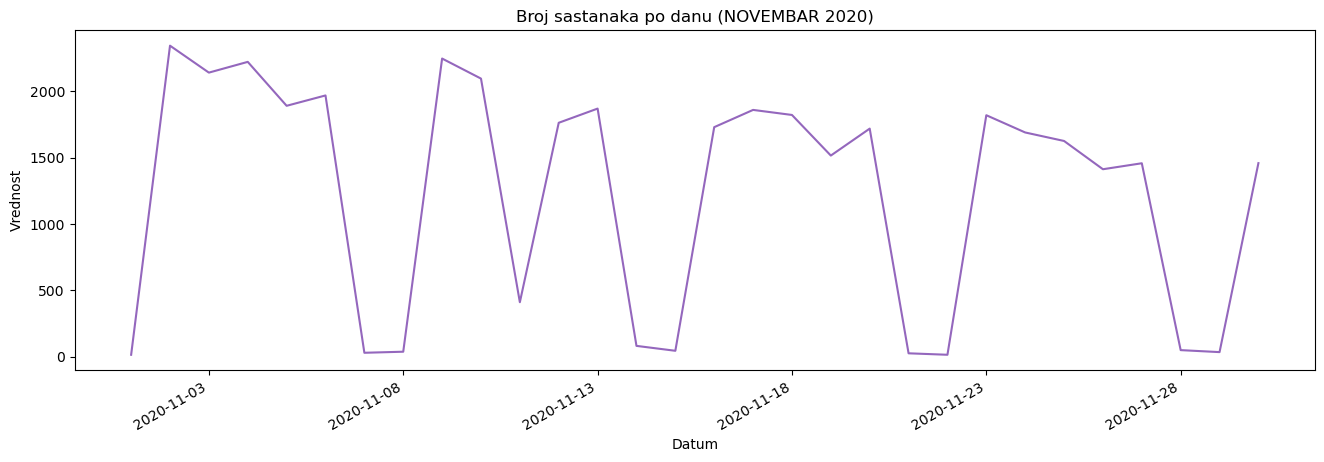

In [73]:
plot_df(meetings_per_day_november, meetings_per_day_november.index, meetings_per_day_november.values, title="Broj sastanaka po danu (NOVEMBAR 2020)")

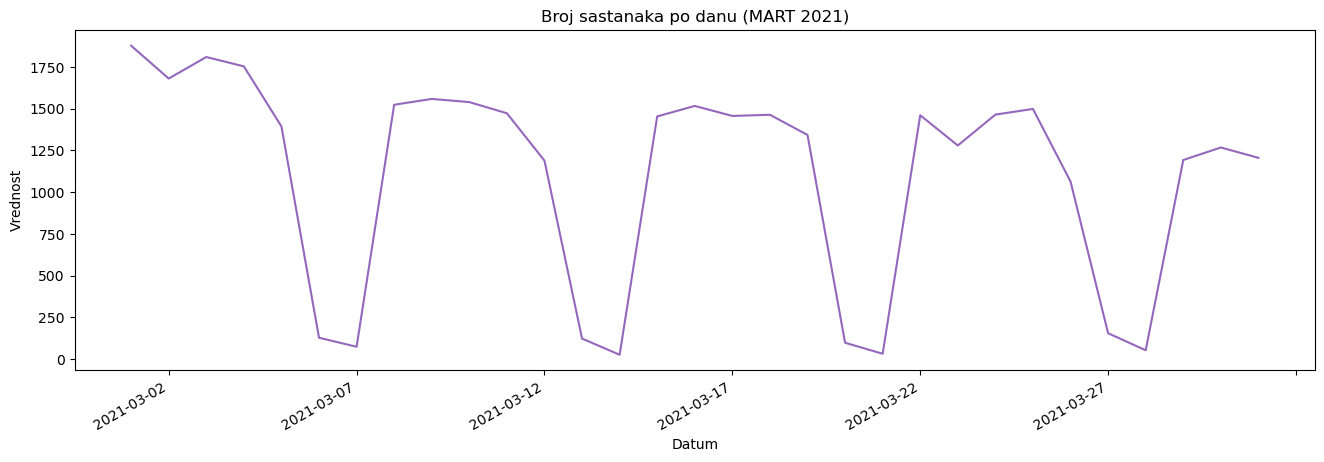

In [74]:
plot_df(meetings_per_day_march, meetings_per_day_march.index, meetings_per_day_march.values, title="Broj sastanaka po danu (MART 2021)")

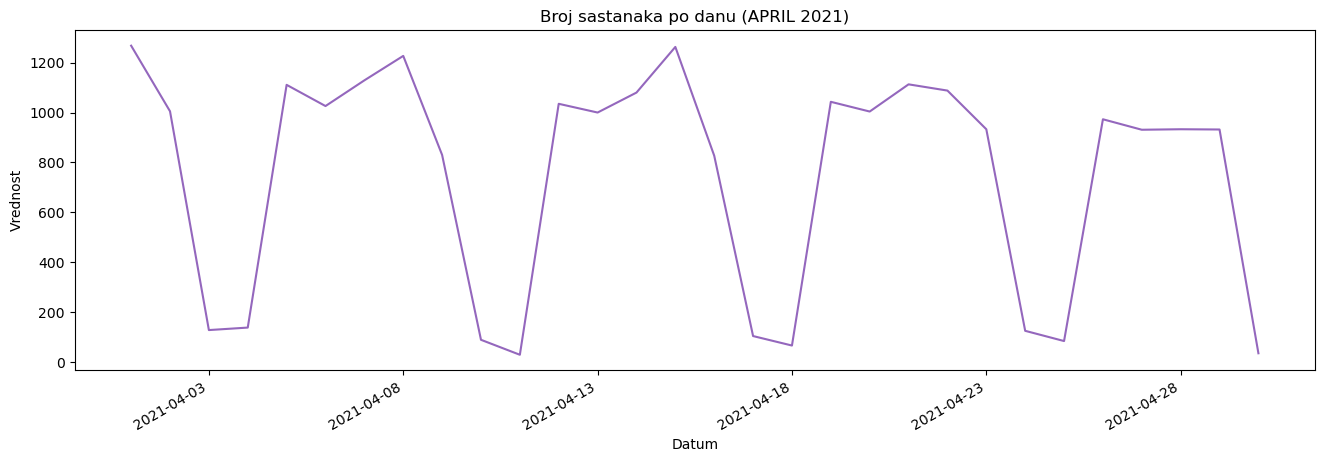

In [75]:
plot_df(meetings_per_day_april, meetings_per_day_april.index, meetings_per_day_april.values, title="Broj sastanaka po danu (APRIL 2021)")

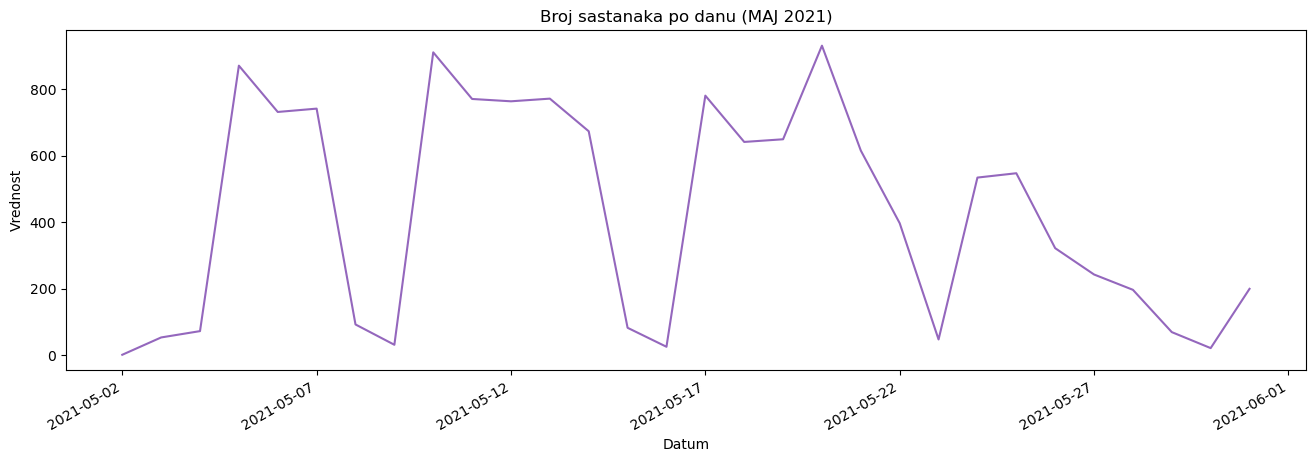

In [76]:
plot_df(meetings_per_day_may, meetings_per_day_may.index, meetings_per_day_may.values, title="Broj sastanaka po danu (MAJ 2021)")

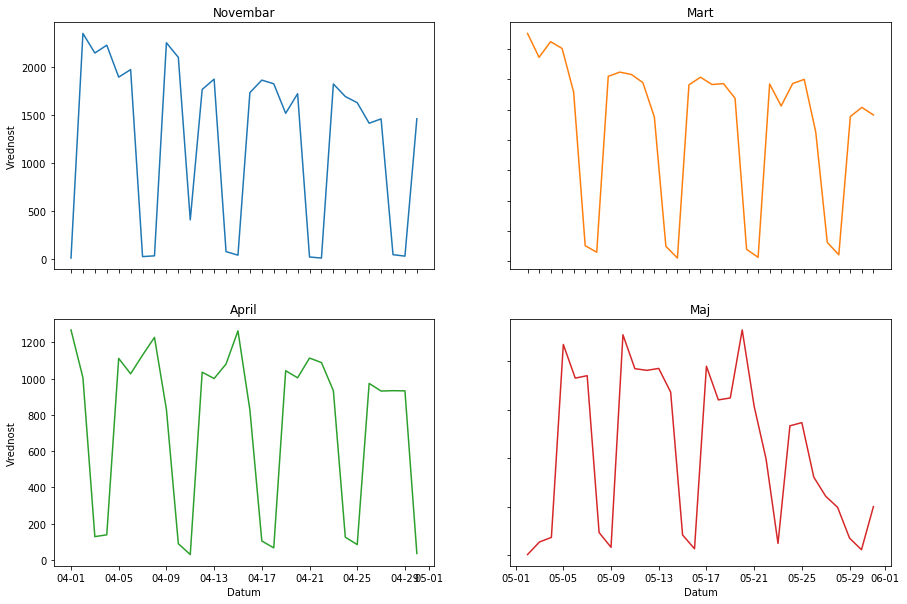

In [77]:
fig, axs = plt.subplots(2, 2, figsize=(15,10))
date_form = DateFormatter("%m-%d")


axs[0, 0].plot(meetings_per_day_november.index, meetings_per_day_november.values)
axs[0, 0].set_title('Novembar')
axs[0, 1].plot(meetings_per_day_march.index, meetings_per_day_march.values, 'tab:orange')
axs[0, 1].set_title('Mart')
axs[1, 0].plot(meetings_per_day_april.index, meetings_per_day_april.values, 'tab:green')
axs[1, 0].set_title('April')
axs[1, 0].xaxis.set_major_formatter(date_form)
axs[1, 1].plot(meetings_per_day_may.index, meetings_per_day_may.values, 'tab:red')
axs[1, 1].set_title('Maj')
axs[1, 1].xaxis.set_major_formatter(date_form)


for ax in axs.flat:
    ax.set(xlabel='Datum', ylabel='Vrednost')

for ax in axs.flat:
    ax.label_outer()

Prosecna duzina trajanja sastanaka svaki dan 

In [78]:
#duration_april = april.groupby(['JOIN_DATE']).DURATION.mean()
#plot_df(duration_april, duration_april.index, duration_april.values, title='trajanje april')

In [79]:
#df['Year'] = april.index.year
#df['Month'] = april.index.month
#df['Weekday Name'] = april.index.day_name()

#april.sample(5, random_state=2)

### Stationarity

Vremenska serija je stacionarna ako:
- ima konstantnu srednju vrednost
- ima konstantnu varijansu
- nema sezonsku komponentu

In [80]:
def check_mean(df, name):
    days = df.shape[0]
    one = days//3
    two = 2*days//3

    print(name + ': ')
    print('Prva trecina: {}'.format(df[:one].mean()))
    print('Druga trecina: {}'.format(df[one:two].mean()))
    print('Treca trecina: {}'.format(df[two:].mean()))
    print('Srednja vrednost na celom skupu: {}\n'.format(df.mean()))

In [81]:
check_mean(meetings_per_day_november, 'NOVEMBAR')
check_mean(meetings_per_day_march, 'MART')
check_mean(meetings_per_day_april, 'APRIL')
check_mean(meetings_per_day_may, 'MAJ')

NOVEMBAR: 
Prva trecina: 1498.3
Druga trecina: 1280.8
Treca trecina: 958.2
Srednja vrednost na celom skupu: 1245.7666666666667

MART: 
Prva trecina: 1334.2
Druga trecina: 1014.4
Treca trecina: 970.5454545454545
Srednja vrednost na celom skupu: 1102.0

APRIL: 
Prva trecina: 795.1
Druga trecina: 745.1
Treca trecina: 714.7
Srednja vrednost na celom skupu: 751.6333333333333

MAJ: 
Prva trecina: 427.6
Druga trecina: 593.1
Treca trecina: 258.0
Srednja vrednost na celom skupu: 426.23333333333335



 Srednja vrednost je uglavnom konstantna, ali se iz grafika vidi da postoji sezonska komponenta (ponavlja se neki sablon) -> nije stacionarna

### Spajanje u jednu vremensku seriju 

In [82]:
ts = pd.concat([meetings_per_day_november, meetings_per_day_march, meetings_per_day_april, meetings_per_day_may])

In [90]:
ts.name = 'Webex meetings'
ts.shape
ts.index = pd.to_datetime(ts.index, utc=True)

121 dan 

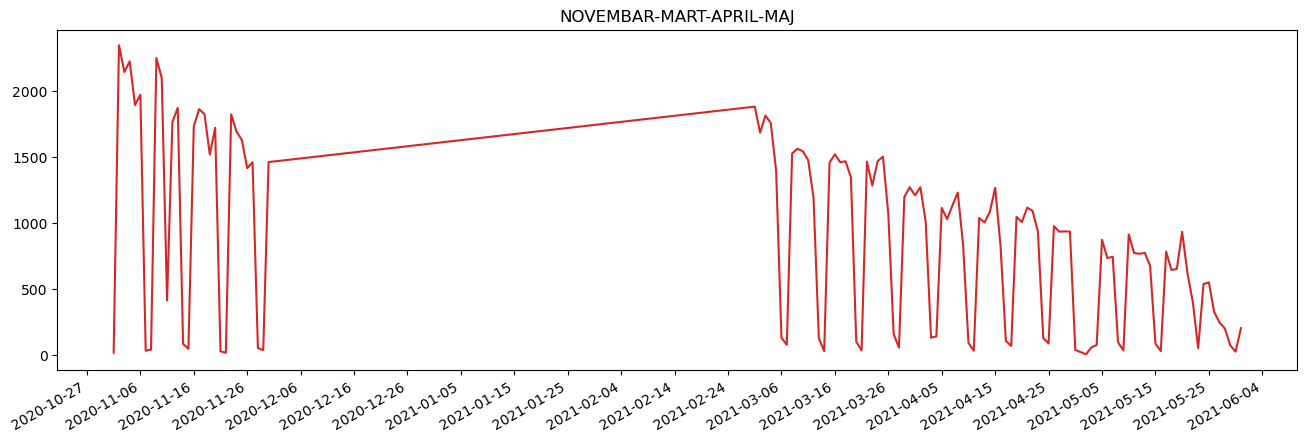

In [101]:
fig = plt.figure(figsize=(16,5), dpi=100)
ax = fig.add_subplot(111)
ax.plot(ts.index, ts.values, 'tab:red')
fig.autofmt_xdate()
plt.title('NOVEMBAR-MART-APRIL-MAJ')
ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))
plt.show()

### Stationarity

In [102]:
check_mean(ts, 'NOVEMBAR-MART-APRIL-MAJ')

NOVEMBAR-MART-APRIL-MAJ: 
Prva trecina: 1267.875
Druga trecina: 880.45
Treca trecina: 510.6829268292683
Srednja vrednost na celom skupu: 883.2314049586777



Srednja vrednost nije konstantna --> nije stacionarna

## Dekompozicija